# Exercise 3 - Quantum error correction

## Historical background

Shor's algorithm gave quantum computers a worthwhile use case—but the inherent noisiness of quantum mechanics meant that building hardware capable of running such an algorithm would be a huge struggle. In 1995, Shor released another landmark paper: a scheme that shared quantum information over multiple qubits in order to reduce errors.[1]

A great deal of progress has been made over the decades since. New forms of error correcting codes have been discovered, and a large theoretical framework has been built around them. The surface codes proposed by Kitaev in 1997 have emerged as the leading candidate, and many variations on the original design have emerged since then. But there is still a lot of progress to make in tailoring codes to the specific details of quantum hardware.[2]

In this exercise we'll consider a case in which artificial 'errors' are inserted into a circuit. Your task is to design the circuit such that these additional gates can be identified.

You'll then need to think about how to implement your circuit on a real device. This means you'll need to tailor your solution to the layout of the qubits. Your solution will be scored on how few entangling gates (the noisiest type of gate) that you use.

### References
1. Shor, Peter W. "Scheme for reducing decoherence in quantum computer memory." Physical review A 52.4 (1995): R2493.
1. Dennis, Eric, et al. "Topological quantum memory." Journal of Mathematical Physics 43.9 (2002): 4452-4505.

## The problem of errors

Errors occur when some spurious operation acts on our qubits. Their effects cause things to go wrong in our circuits. The strange results you may have seen when running on real devices is all due to these errors.

There are many spurious operations that can occur, but it turns out that we can pretend that there are only two types of error: bit flips and phase flips.

Bit flips have the same effect as the `x` gate. They flip the $|0\rangle$ state of a single qubit to $|1\rangle$ and vice-versa. Phase flips have the same effect as the `z` gate, introducing a phase of $-1$ into superpositions. Put simply, they flip the $|+\rangle$ state of a single qubit to $|-\rangle$ and vice-versa.

The reason we can think of any error in terms of just these two is because any error can be represented by some matrix, and any matrix can be written in terms of the matrices $X$ and $Z$. Specifically, for any single qubit matrix $M$,

$$
M = \alpha I + \beta X + \gamma XZ + \delta Z,
$$

for some suitably chosen values $\alpha$, $\beta$, $\gamma$ and $\delta$.

So whenever we apply this matrix to some single qubit state $|\psi\rangle$ we get

$$
M |\psi\rangle = \alpha |\psi\rangle + \beta X |\psi\rangle + \gamma XZ |\psi\rangle + \delta Z |\psi\rangle.
$$

The resulting superposition is composed of the original state, the state we'd have if the error was just a bit flip, the state for just a phase flip and the state for both. If we had some way to measure whether a bit or phase flip happened, the state would then collapse to just one possibility. And our complex error would become just a simple bit or phase flip.

So how do we detect whether we have a bit flip or a phase flip (or both). And what do we do about it once we know? Answering these questions is what quantum error correction is all about.




## An overly simple example

One of the first quantum circuits that most people ever write is to create a pair of entangled qubits. In this journey into quantum error correction, we'll start the same way.

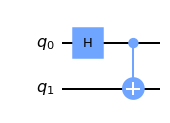

{'11': 573, '00': 451}

In [1]:
from qiskit import QuantumCircuit, Aer

# Make an entangled pair
qc_init = QuantumCircuit(2)
qc_init.h(0)
qc_init.cx(0,1)

# Draw the circuit
display(qc_init.draw('mpl'))

# Get an output
qc = qc_init.copy()
qc.measure_all()
job = Aer.get_backend('qasm_simulator').run(qc)
job.result().get_counts()

Here we see the expected result when we run the circuit: the results `00` and `11` occurring with equal probability.

But what happens when we have the same circuit, but with a bit flip 'error' inserted manually.

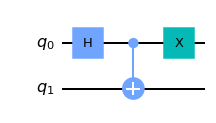

{'01': 505, '10': 519}

In [2]:
# Make bit flip error
qc_insert = QuantumCircuit(2)
qc_insert.x(0)

# Add it to our original circuit
qc = qc_init.copy()
qc = qc.compose(qc_insert)

# Draw the circuit
display(qc.draw('mpl'))

# Get an output
qc.measure_all()
job = Aer.get_backend('qasm_simulator').run(qc)
job.result().get_counts()

Now the results are different: `01` and `10`. The two bit values have gone from always agreeing to always disagreeing. In this way, we detect the effect of the error.

Another way we can detect it is to undo the entanglement with a few more gates. If there are no errors, we return to the initial $|00\rangle$ state.

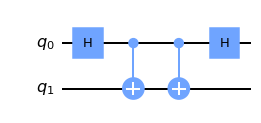

{'00': 1024}

In [3]:
# Undo entanglement
qc_syn = QuantumCircuit(2)
qc_syn.cx(0,1)
qc_syn.h(0)

# Add this after the error
qc = qc_init.copy()
qc = qc.compose(qc_syn)

# Draw the circuit
display(qc.draw('mpl'))

# Get an output
qc.measure_all()
job = Aer.get_backend('qasm_simulator').run(qc)
job.result().get_counts()

But what happens if there are errors one of the qubits? Try inserting different errors to find out.

Here's a circuit with all the components we've introduced so far: the initialization `qc_init`, the inserted error in `qc_insert` and the final `qc_syn` which ensures that the final measurement gives a nice definite answer.

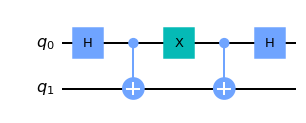

{'10': 1024}

In [4]:
# Define an error
qc_insert = QuantumCircuit(2)
qc_insert.x(0)

# Undo entanglement
qc_syn = QuantumCircuit(2)
qc_syn.cx(0,1)
qc_syn.h(0)

# Add this after the error
qc = qc_init.copy()
qc = qc.compose(qc_insert)
qc = qc.compose(qc_syn)

# Draw the circuit
display(qc.draw('mpl'))

# Get an output
qc.measure_all()
job = Aer.get_backend('qasm_simulator').run(qc)
job.result().get_counts()

You'll find that the output tells us exactly what is going on with the errors. Both the bit and phase flips can be detected. The bit value on the left is `1` only if there is a bit flip (and so if we have inserted an `x(0)` or `x(1)`). The bit on the right similarly tells us there is a phase flip (an inserted `z(0)` or `z(1)`).

This ability to detect and distinguish bit and phase flips is very useful. But it is not quite useful enough. We can only tell *what type* of errors are happening, but not *where*. Without more detail, it is not possible to figure out how to remove the effects of these operations from our computations. For quantum error correction we therefore need something bigger and better.

It's your task to do just that! Here's a list of what you need to submit. Everything here is then explained by the example that follows.

<div class="alert alert-block alert-success">

<b>Goal</b>

Create circuits which can detect `x` and `z` errors on two qubits.
You can come up with a solution of your own. Or just tweak the almost valid solution given below.

</div>

<div class="alert alert-block alert-danger">
<b>What to submit</b> 

* You need to supply two circuits:
    * `qc_init`: Prepares the qubits (of which there are at least two) in a desired initial state;
    * `qc_syn`: Measures a subset of the qubits.

* The artificial errors to be inserted are `x` and `z` gates on two particular qubits. You need to pick the two qubits to be used for this (supplied as the list `error_qubits`).

* There are 16 possible sets of errors to be inserted (including the trivial case of no errors). The measurement result of `qc_syn` should output a unique bit string for each. The grader will return the error message *'Please make sure the circuit is created to the initial layout.'* if this is not satisfied.

* The grader will compile the complete circuit for the backend `ibmq_tokyo` (a retired device). To show that your solution is tailor made for the device, this transpilation should not change the number of `cx` gates. If it does, you will get the error message *'Please make sure the circuit is created to the initial layout.'*
    
* To guide the transpilation, you'll need to tell the transpiler which qubits on the device should be used as which qubits in your circuit. This is done with an `initial_layout` list.
    
* You may start with the example given below, which can become a valid answer with a few tweaks.
</div>

## A better example: the surface code

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile

import qiskit.tools.jupyter
from qiskit.test.mock import FakeTokyo

In this example we'll use 5 qubits that we'll call code qubits. To keep track of them, we'll define a special quantum register.

In [6]:
code = QuantumRegister(5,'code')

We'll also have an additional four qubits we'll call syndrome qubits.

In [7]:
syn = QuantumRegister(4,'syn')

Similarly we define a register for the four output bits, used when measuring the syndrome qubits.

In [8]:
out = ClassicalRegister(4,'output')

We consider the qubits to be laid out as follows, with the code qubits forming the corners of four triangles, and the syndrome qubits living inside each triangle.

```
c0----------c1
| \   s0   / |
|   \    /   |
| s1  c2  s2 |
|   /    \   |
| /   s3   \ |
c3----------c4
```

For each triangle we associate a stabilizer operation on its three qubits. For the qubits on the sides, the stabilizers are ZZZ. For the top and bottom ones, they are XXX.

The syndrome measurement circuit corresponds to a measurement of these observables. This is done in a similar way to surface code stabilizers (in fact, this code is a small version of a surface code).
<div class="alert alert-block alert-danger">
 
<b>Warning</b> 

You should remove the barriers before submitting the code as it might interfere with transpilation. It is given here for visualization only. 
</div>

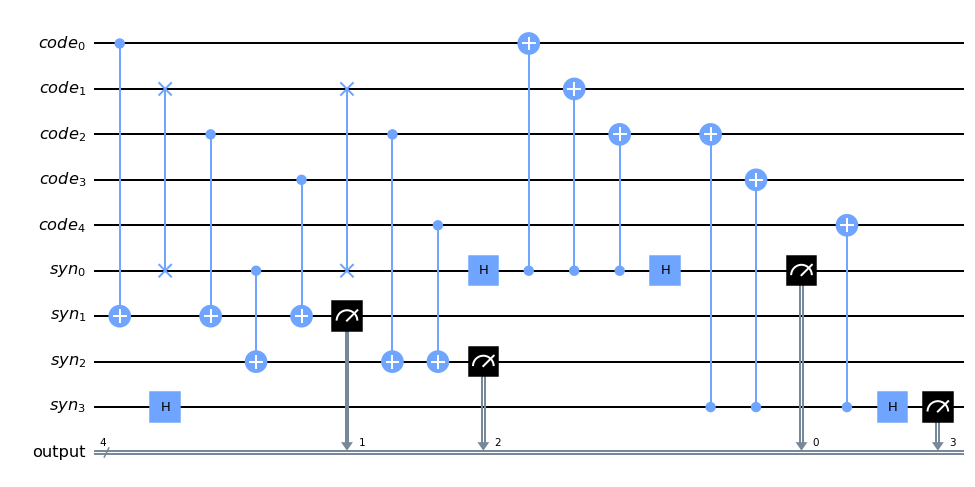

In [9]:
qc_syn = QuantumCircuit(code,syn,out)


# Left ZZZ
qc_syn.cx(code[0],syn[1])
qc_syn.cx(code[2],syn[1])
qc_syn.cx(code[3],syn[1])
#qc_syn.barrier()

# Right ZZZ
qc_syn.swap(code[1],syn[0])
#qc_syn.cx(code[1],syn[0])
#qc_syn.cx(syn[0],code[1])
#qc_syn.cx(code[1],syn[0])

#qc_syn.cx(code[1],syn[2])
qc_syn.cx(syn[0],syn[2])

qc_syn.swap(code[1],syn[0])
#qc_syn.cx(code[1],syn[0])
#qc_syn.cx(syn[0],code[1])
#qc_syn.cx(code[1],syn[0])

qc_syn.cx(code[2],syn[2])
qc_syn.cx(code[4],syn[2])
#qc_syn.barrier()

# Top XXX
qc_syn.h(syn[0])
qc_syn.cx(syn[0],code[0])
qc_syn.cx(syn[0],code[1])
qc_syn.cx(syn[0],code[2])
qc_syn.h(syn[0])
#qc_syn.barrier()

# Bottom XXX
qc_syn.h(syn[3])
qc_syn.cx(syn[3],code[2])
qc_syn.cx(syn[3],code[3])
qc_syn.cx(syn[3],code[4])
qc_syn.h(syn[3])
#qc_syn.barrier()


# Measure the auxilliary qubits
qc_syn.measure(syn,out)
qc_syn.draw('mpl')

The initialization circuit prepares an eigenstate of these observables, such that the output of the syndrome measurement will be `0000` with certainty.

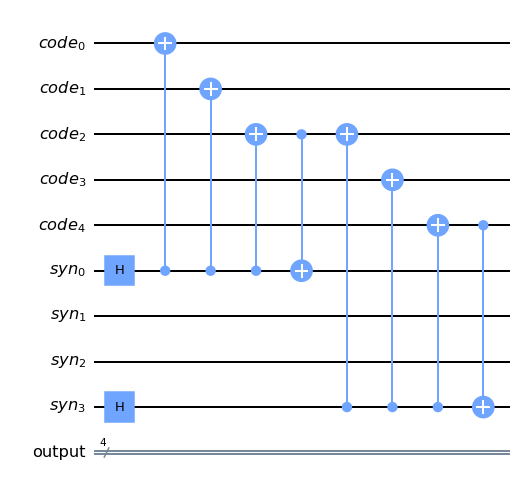

In [10]:
qc_init = QuantumCircuit(code,syn,out)

qc_init.h(syn[0])
qc_init.cx(syn[0],code[0])
qc_init.cx(syn[0],code[1])
qc_init.cx(syn[0],code[2])
qc_init.cx(code[2],syn[0])

qc_init.h(syn[3])
qc_init.cx(syn[3],code[2])
qc_init.cx(syn[3],code[3])
qc_init.cx(syn[3],code[4])
qc_init.cx(code[4],syn[3])

#qc_init.barrier()
qc_init.draw('mpl')

Let's check that is true.

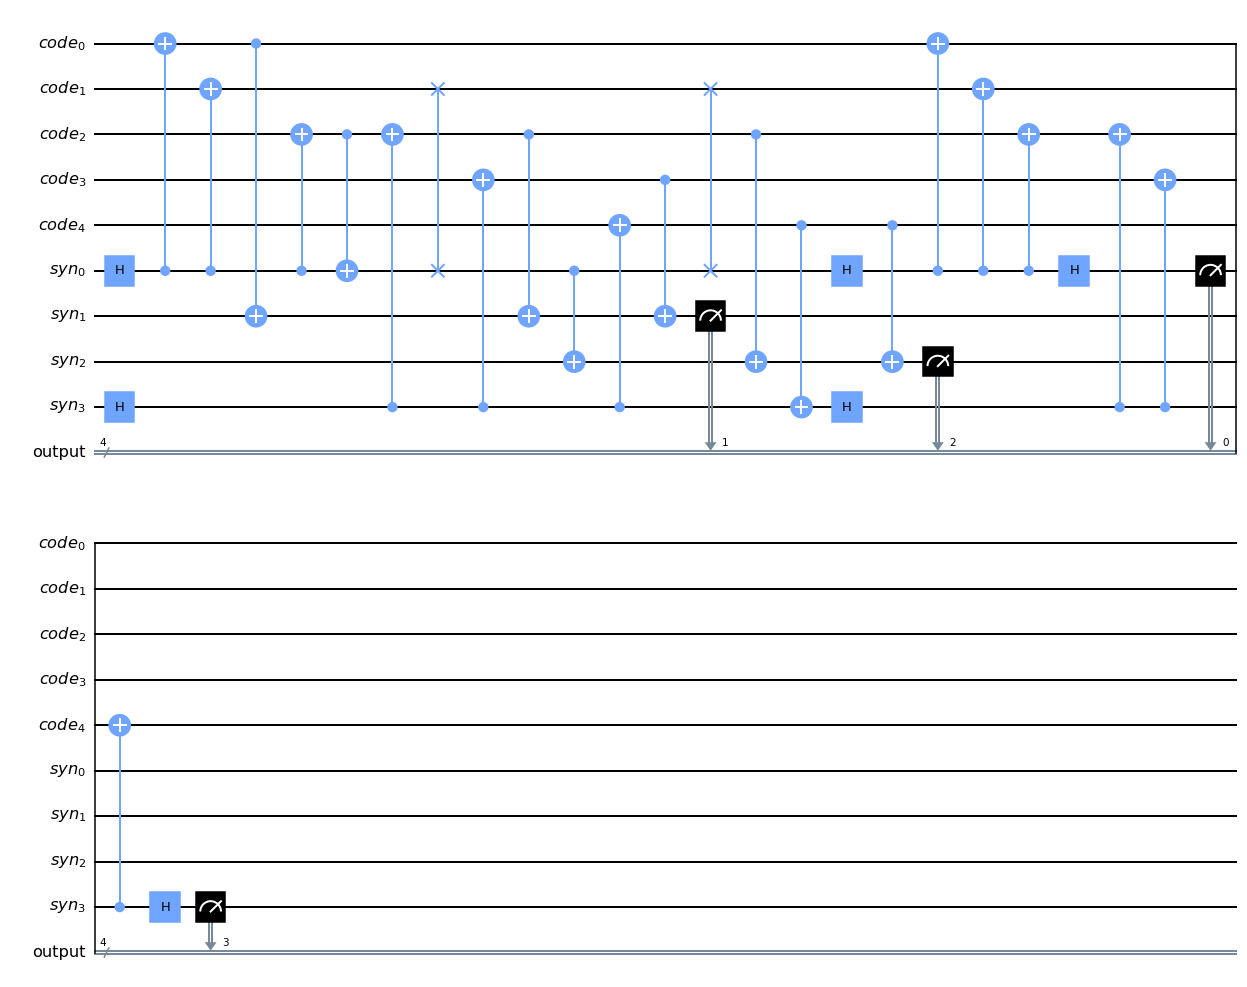

{'0000': 1024}

In [11]:
qc = qc_init.compose(qc_syn)
display(qc.draw('mpl'))

job = Aer.get_backend('qasm_simulator').run(qc)
job.result().get_counts()

Now let's make a circuit with which we can insert `x` and `z` gates on our two code qubits. For this we'll need to choose which of the 5 code qubits we have will correspond to the two required for the validity condition.

For this code we need to choose opposite corners.

In [12]:
error_qubits = [0,4]

Here 0 and 4 refer to the positions of the qubits in the following list, and hence are qubits `code[0]` and `code[4]`.

In [13]:
qc.qubits

[Qubit(QuantumRegister(5, 'code'), 0),
 Qubit(QuantumRegister(5, 'code'), 1),
 Qubit(QuantumRegister(5, 'code'), 2),
 Qubit(QuantumRegister(5, 'code'), 3),
 Qubit(QuantumRegister(5, 'code'), 4),
 Qubit(QuantumRegister(4, 'syn'), 0),
 Qubit(QuantumRegister(4, 'syn'), 1),
 Qubit(QuantumRegister(4, 'syn'), 2),
 Qubit(QuantumRegister(4, 'syn'), 3)]

To check that the code does as we require, we can use the following function to create circuits for inserting artificial errors. Here the errors we want to add are listed in `errors` as a simple text string, such as `x0` for an `x` on `error_qubits[0]`.

In [14]:
def insert(errors,error_qubits,code,syn,out):

    qc_insert = QuantumCircuit(code,syn,out)

    if 'x0' in errors:
        qc_insert.x(error_qubits[0])
    if 'x1' in errors:
        qc_insert.x(error_qubits[1])
    if 'z0' in errors:
        qc_insert.z(error_qubits[0])
    if 'z1' in errors:
        qc_insert.z(error_qubits[1])
        
    return qc_insert

Rather than all 16 possibilities, let's just look at the four cases where a single error is inserted.

In [15]:
for error in ['x0','x1','z0','z1']:
    
    qc = qc_init.compose(insert([error],error_qubits,code,syn,out)).compose(qc_syn)
    job = Aer.get_backend('qasm_simulator').run(qc)
    
    print('\nFor error '+error+':')
    counts = job.result().get_counts()
    for output in counts:
        print('Output was',output,'for',counts[output],'shots.')


For error x0:
Output was 0010 for 1024 shots.

For error x1:
Output was 0100 for 1024 shots.

For error z0:
Output was 0001 for 1024 shots.

For error z1:
Output was 1000 for 1024 shots.


Here we see that each bit in the output is `1` when a particular error occurs: the leftmost detects `z` on `error_qubits[1]`, then the next detects `x` on `error_qubits[1]`, and so on.

<div class="alert alert-block alert-danger">
 
<b>Attention</b> 

The correct ordering of the output is important for this exercise. Please follow the order as given below:
1. The leftmost output represents `z` on `code[1]`.
2. The second output from left represents `x` on `code[1]`.
3. The third output from left represents `x` on `code[0]`.
4. The rightmost output represents `z` on `code[0]`.
    
</div>

When more errors affect the circuit, it becomes hard to unambiguously tell which errors occurred. However, by continuously repeating the syndrome readout to get more results and analysing the data through the process of decoding, it is still possible to determine enough about the errors to correct their effects.

These kinds of considerations are beyond what we will look at in this challenge. Instead we'll focus on something simpler, but just as important: the fewer errors you have, and the simpler they are, the better your error correction will be. To ensure this, your error correction procedure should be tailor-made to the device you are using.

In this challenge we'll be considering the device `ibmq_tokyo`. Though the real version of this was retired some time ago, it still lives on as one of the mock backends.

In [16]:
# Please use the backend given here
backend = FakeTokyo()
backend

<FakeTokyo('fake_tokyo') from None()>

As a simple idea of how our original circuit is laid out, let's see how many two-qubit gates it contains.

In [17]:
qc = qc_init.compose(qc_syn)
qc = transpile(qc, basis_gates=['u','cx'])
qc.num_nonlocal_gates()

26

If we were to transpile it to the `ibmq_tokyo` backend, remapping would need to occur at the cost of adding for two-qubit gates.

In [18]:
qc1 = transpile(qc,backend,basis_gates=['u','cx'], optimization_level=3)
qc1.num_nonlocal_gates()

26

We can control this to an extent by looking at which qubits on the device would be best to use as the qubits in the code. If we look at what qubits in the code need to be connected by two-qubit gates in `qc_syn`, we find the following required connectivity graph.

```
c0....s0....c1
:      :     :        
:      :     :
s1....c2....s2
:      :     :
:      :     :
c3....s3....c4
```

No set of qubits on `ibmq_tokyo` can provide this, but certain sets like 0,1,2,5,6,7,10,11,12 come close. So we can set an `initial_layout` to tell the transpiler to use these.



In [19]:
initial_layout = [0,2,6,10,12,1,5,7,11]

These tell the transpiler which qubits on the device to use for the qubits in the circuit (for the order they are listed in `qc.qubits`). So the first five entries in this list tell the circuit which qubits to use as the code qubits and the next four entries in this list are similarly for the syndrome qubits. So we use qubit 0 on the device as `code[0]`, qubit 2 as `code[1]` and so on.

Now let's use this for the transpilation.

In [20]:
qc2 = transpile(qc,backend,initial_layout=initial_layout, basis_gates=['u','cx'], optimization_level=3)
qc2.num_nonlocal_gates()

26

Though transpilation is a random process, you should typically find that this uses less two-qubit gates than when no initial layout is provided (you might need to re-run both transpilation code multiple times to see it as transpilation is a random process).

Nevertheless, a properly designed error correction scheme should not need any remapping at all. It should be written for the exact device used, and the number of two-qubit gates should remain constant with certainty. This is a condition for a solution to be valid. So you'll not just need to provide an `initial_layout`, but also design your circuits specifically for that layout.

But that part we leave up to you!

In [21]:
# Check your answer using following code
from qc_grader import grade_ex3
grade_ex3(qc_init,qc_syn,error_qubits,initial_layout)

Grading your answer for ex3. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 266.
Feel free to submit your answer.



In [22]:
# Submit your answer. You can re-submit at any time.
from qc_grader import submit_ex3
submit_ex3(qc_init,qc_syn,error_qubits,initial_layout)

Submitting your answer for ex3. Please wait...
Success 🎉! Your answer has been submitted.


# Additional information

**Created by:** James Wootton, Rahul Pratap Singh

**Version:** 1.0.0